In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import zscore
import warnings
import baltic as bt
import logomaker
import os
warnings.simplefilter('ignore')

In [2]:
os.makedirs('../Figure/Supplementary Figure5', exist_ok=True)

# Load raw data

In [3]:
family = 'L1P_5end'

Dfam_RM = pd.read_csv('../data/TE/{}.annotation.csv'.format(family))
Dfam_RM.index = Dfam_RM['repeat name']
screening_result = pd.read_csv('../data/screening/{}_screening.csv'.format(family))
Lift_summary_df = pd.read_csv('../data/Liftover/{}_Liftover.csv'.format(family), index_col=0)
Lift_df = pd.read_csv('../data/Liftover/{}_Liftover_rate.csv'.format(family), index_col=0)
KZFP_df = pd.read_csv('../data/overlap/{}_KZFP.csv'.format(family))
MSA_df = pd.read_csv('../data/MSA/{}_MSA.csv'.format(family), index_col=0)
MSA_df.columns = list(map(int, MSA_df.columns))
tree = bt.loadNewick('../data/phylogenetic tree/{}_reroot.contree'.format(family))

In [4]:
# obtain TE targets
KZFP_target = pd.read_csv('../data/targets/TE_targets_for_analysis.csv')
KZFP_target = KZFP_target[KZFP_target['repeat family name']==family]
display(KZFP_target.head())

,KZFP gene symbol,repeat subfamily name,ratio,p value,q value,log10 q value,normalized score,rank,criteria,overlap peak count to all copies,...,repeat class,repeat classification,emergence era of TE subfamily,evolutionary age of TE subfamily,emegence era of TE subfamily is in primate,emergence era of KZFP for analysis,evolutionary age of KZFP for analysis,evolutionary age of KZFP in Imbeault et al.,evolutionary age of KZFP in Tribolet-Hardy et al.,emegence era of KZFP is in primate
0,ZNF93,L1P1_5end,150.130049,0.000000e+00,3.611620e-321,320.442298,1.000000,Primary,True,1718,...,LINE,L1,Hominoidea,20.2,True,Homininae,9.1,19.9,9.1,True
1,ZNF93,L1P2_5end,65.562098,0.000000e+00,3.611620e-321,320.442298,1.000000,Primary,True,527,...,LINE,L1,Catarrhini,29.4,True,Homininae,9.1,19.9,9.1,True
7,ZNF891,L1HS_5end,7.125002,0.000000e+00,2.406100e-321,320.618686,1.000000,Primary,True,1114,...,LINE,L1,Homininae,9.1,True,Eutheria,105.0,105.0,105.0,False
18,ZNF891,L1P1_5end,2.484840,1.719865e-84,1.796031e-82,81.745686,0.254962,Secondary,True,603,...,LINE,L1,Hominoidea,20.2,True,Eutheria,105.0,105.0,105.0,False
28,ZNF879,L1PA15-16_5end,9.063319,4.158008e-57,6.079007e-54,53.216167,1.000000,Primary,True,96,...,LINE,L1,Simiiformes,43.2,True,Eutheria,105.0,105.0,105.0,False


In [5]:
# motif metadata
motif_metadata_df = pd.read_csv('../data/motif/TE_KZFP_binding_sites.csv')

# filtering
condition1 = (motif_metadata_df['discovery proportion']>=50) & (motif_metadata_df['log10 p-value']>=4)
condition2 = motif_metadata_df['motif start'] != motif_metadata_df['motif end']
condition3 = motif_metadata_df['repeat family name']==family
motif_metadata_df_fil = motif_metadata_df[condition1 & condition2 & condition3].sort_values(by='log10 p-value', ascending=False)
motif_metadata_df_nodup = motif_metadata_df_fil[motif_metadata_df_fil[['repeat family name', 'KZFP gene symbol']].duplicated()==False]
motif_metadata_df_nodup

,repeat family name,KZFP gene symbol,KZFP experiment,motif start,motif end,motif center,motif strand,peak overlap motif,discovery proportion,distance to peak summit,log10 p-value,E-value significant figure,E-value log10
25,L1P_5end,ZNF354B,ENCSR044IXA,4941.0,4966.0,4953,+,629.0,75.419664,14.926868,14.829738,3.2,257
11,L1P_5end,ZNF649,GSE78099,346.0,368.0,357,+,1871.0,83.938986,21.325494,13.046724,7.8,353
13,L1P_5end,ZNF528,GSE78099,530.0,548.0,539,-,570.0,68.840580,11.743860,8.596879,2.7,773
0,L1P_5end,ZNF136,GSE78099,4576.0,4596.0,4586,-,2172.0,68.452569,14.186004,8.211125,7.3,375
14,L1P_5end,ZNF17,GSE78099,1276.0,1290.0,1283,+,257.0,55.268817,17.560311,6.166216,6.4,210
8,L1P_5end,ZNF317,ENCSR976MXN,4488.0,4501.0,4494,-,7257.0,77.424517,15.348491,6.044312,4.5,302
17,L1P_5end,ZNF93,GSE78099,1890.0,1904.0,1897,+,885.0,61.543811,8.641808,5.749580,9.7,376
24,L1P_5end,ZNF735,GSE200964,3759.0,3778.0,3768,+,50.0,64.935065,11.000000,5.649752,4.4,948
26,L1P_5end,ZNF529,ENCSR754SOI,4966.0,4986.0,4976,+,313.0,79.643766,15.383387,5.490797,2.7,208
16,L1P_5end,ZNF765,GSE78099,1088.0,1102.0,1095,+,1153.0,89.449185,11.363400,5.441291,1.6,395


In [6]:
# motif

from Bio import motifs

motif_matrix_df = dict()
for KZFP, exp in motif_metadata_df_nodup[['KZFP gene symbol', 'KZFP experiment']].value_counts().index:

    with open('../data/motif/raw_motif/{}_{}_motif_sig_500_231120.meme'.format(KZFP, exp)) as f:

        fr = f.read().split('\n')

        check = False
        motif_list = list()
        for line in fr:

            if 'letter' in line:
                check = True
            
            elif check and '\t' in line:

                value = [float(i) for i in line.replace(' ', '').split('\t')[:4]]
                motif_list.append(value)
        
    df = pd.DataFrame(motif_list, columns=['A', 'C', 'G', 'T'])
    motif_matrix_df[KZFP] = df

# Process raw data

In [7]:
# 制限する
KZFP_df_fil = KZFP_df[KZFP_df['KZFP gene symbol'].isin(pd.unique(KZFP_target['KZFP gene symbol']))]

In [8]:
# カラーをつける
color_dict = dict()
color_name_dict = dict()

color_list = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink']
branch_list = ['Vertebrata', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria', 'Boreoeutheria', 'Euarchontoglires', 'Primatomorpha', 
               'Primates', 'Haplorrhini', 'Simiiformes', 'Catarrhini', 'Hominoidea', 'Hominidae', 'Homininae', 'Hominini']

L1_class_list = [['L1PA17_5end', 'L1PA15-16_5end', 'L1PA14_5end', 'L1PA13_5end', 'L1PA12_5end', 'L1PA10_5end'],
                 ['L1PBb_5end', 'L1PBa_5end', 'L1PBa1_5end'],
                 ['L1P4a_5end', 'L1P4b_5end', 'L1P4c_5end', 'L1P4d_5end', 'L1P4e_5end'],
                 ['L1P3b_5end', 'L1P3_5end'],
                 ['L1PREC2_5end'], ['L1P2_5end'], ['L1P1_5end'], ['L1HS_5end']]

#color_list = ['blue', 'skyblue', 'lightgreen', 'green', 'yellow', 'orange', 'pink', 'red']


for i, (subfamily_list, color) in enumerate(zip(L1_class_list, color_list)):

    for subfamily in subfamily_list:

        color_dict[subfamily] = color

        
for i, (subfamily, name) in enumerate(Dfam_RM[['repeat subfamily name', 'repeat name']].values):

    color_name_dict[name] = color_dict[subfamily]

c_func = lambda x: color_name_dict[x.name] if x.name in color_name_dict.keys() else 'black'
x_attr= lambda x: x.absoluteTime

# Supplementary Fig.5A

In [9]:
# KZFP binding to each copy
crosstab = pd.crosstab(KZFP_df_fil['repeat name'], KZFP_df_fil['KZFP gene symbol'])
Dfam_RM_KZFP = pd.concat([Dfam_RM, crosstab>=1], axis=1)
Dfam_RM_KZFP = Dfam_RM_KZFP[Dfam_RM_KZFP['repeat name'].isna()==False]
Dfam_RM_KZFP = Dfam_RM_KZFP.fillna(False)

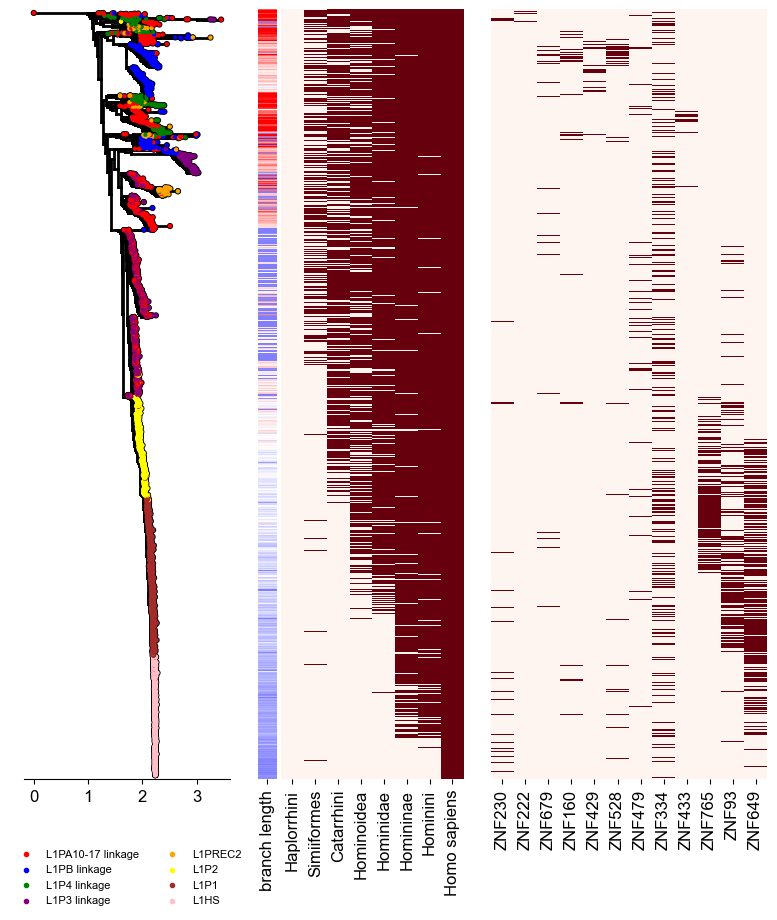

In [10]:
# visualization of phylogenetic tree
fig = plt.figure(figsize=[15, 10])
gs = GridSpec(20, 50)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

ax = plt.subplot(gs[:, :9])
i = 10

tree.plotTree(ax) ## plot branches
tree.plotPoints(ax, colour=c_func, size=10, zorder=100) ## plot circles at tips

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right','left']]

ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax.set_ylim(-50,tree.ySpan+50)
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

# Legend
legend_elements = []
name_list = ['L1PA10-17 linkage', 'L1PB linkage', 'L1P4 linkage', 'L1P3 linkage', 'L1PREC2', 'L1P2', 'L1P1', 'L1HS']
for name, color in zip(name_list, color_list):
    p = ax.scatter([-1], [-1], marker='.', label=name, color=color)

ax.legend(loc=[-0.07, -0.17], ncol=2, fontsize=8, frameon=False)

# branch length
ax = plt.subplot(gs[:, i])
i += 1

data = zscore(Dfam_RM.loc[reversed(Dfam_RM_KZFP.index)]['branch length'].to_frame())
sns.heatmap(data, cmap='bwr', vmin=-2, center=0, vmax=2, cbar=False, ax=ax)

ax.set_xticklabels(['branch length'], rotation=90)
ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)


# Liftover
branch = branch_list[-7:] + ['Homo sapiens']

ax = plt.subplot(gs[:, i:i+len(branch)])
i += len(branch)

data = Lift_summary_df[branch].loc[reversed(Dfam_RM_KZFP.index)]
sns.heatmap(data, cmap='Reds', cbar=False, ax=ax)
ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)

# KRAB-ZFP evaded by TE
KRAB_list = pd.unique(screening_result['KZFP gene symbol'])
KRAB_list = ['ZNF230', 'ZNF222', 'ZNF679', 'ZNF160', 'ZNF429', 'ZNF528', 'ZNF479', 'ZNF334', 'ZNF433', 'ZNF765', 'ZNF93', 'ZNF649']

ax = plt.subplot(gs[:, i+1:i+len(KRAB_list)+1])
i += len(KRAB_list) + 1

data = Dfam_RM_KZFP[KRAB_list].loc[reversed(Dfam_RM_KZFP.index)]
sns.heatmap(data, cmap='Reds', cbar=False, ax=ax)
ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)

plt.savefig('../Figure/Supplementary Figure5/Supplementary Figure5A.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure5/Supplementary Figure5A.pdf', bbox_inches='tight', transparent=True, dpi=300)

plt.show()

# Supplementary Fig.5B

## ZNF765

In [11]:
gene = 'ZNF765'

In [12]:
# process data
motif = motif_metadata_df_nodup[motif_metadata_df_nodup['KZFP gene symbol']==gene]
motif_start, motif_end = motif[['motif start', 'motif end']].values.astype('int64')[0]

# annotation
Dfam_RM_fil = Dfam_RM[Dfam_RM['repeat subfamily name'].isin(['L1P1_5end', 'L1HS_5end'])]
Dfam_RM_fil = Dfam_RM_fil.loc[reversed(Dfam_RM_fil.index)]

# MSA
MSA = MSA_df.loc[Dfam_RM_fil['repeat name']]

# KZFP
start, end = motif_start-50, motif_end+50
KZFP = KZFP_df[(KZFP_df['KZFP gene symbol']==gene) & (KZFP_df['summit position in repeat alignment']>=start) & (KZFP_df['summit position in repeat alignment']<=end) ]


In [13]:
# motif
motif_metadata = motif_metadata_df_nodup[motif_metadata_df_nodup['KZFP gene symbol']==gene]
motif = motif_matrix_df[gene][['A', 'C', 'G', 'T']]

if motif_metadata['motif strand'].values[0] == '-':

    motif = motif.sort_index(ascending=False)[['T', 'G', 'C', 'A']]

sequence = ''
for position in motif.index:

    v = motif.loc[position].sort_values(ascending=False)
    b = v.index[0]
    
    sequence += b

print(sequence)
sequence = list(sequence.lower())

CAGGGCCTAGCCCAG


In [14]:
# consensus sequence derived by TE copies overlapping with KZFP peaks

MSA_KZFP = MSA[MSA.index.isin(KZFP['repeat name'])]
consensus_with_KZFP = ''
consensus_matrix_with_KZFP = list()

for position in MSA_KZFP.columns:

    count = MSA_KZFP[position].value_counts(normalize=True).rename(position)
    consensus_matrix_with_KZFP.append(count)

consensus_matrix_with_KZFP = pd.concat(consensus_matrix_with_KZFP, axis=1).T.fillna(0)
consensus_matrix_with_KZFP = consensus_matrix_with_KZFP[['a', 'g', 'c', 't', '-']]
consensus_matrix_with_KZFP.columns = ['A', 'G', 'C', 'T', '-']

# remove deletion
consensus_matrix_with_KZFP_not_deletion = consensus_matrix_with_KZFP[consensus_matrix_with_KZFP['-']<0.5]
consensus_matrix_with_KZFP_not_deletion = consensus_matrix_with_KZFP_not_deletion.loc[motif_start-1:motif_end-1]
not_deletion_index = consensus_matrix_with_KZFP_not_deletion.index

consensus_with_KZFP = ''
for position in consensus_matrix_with_KZFP_not_deletion.index:
    
    count = MSA_KZFP[position].value_counts(normalize=True)
    consensus_with_KZFP += count.index[0]

In [15]:
# MSA for heatmap
heatmap = MSA.T.loc[not_deletion_index].T

for col, base in zip(heatmap.columns, consensus_with_KZFP):
    
    heatmap[col] = heatmap[col]==base

MSA.T.loc[not_deletion_index].T

,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101
L1P1_5end_chrX_dup29,c,a,g,g,g,c,a,t,a,g,c,c,a,a,a
L1HS_5end_chr3_dup46,c,a,g,g,g,c,a,t,a,g,c,t,g,a,a
L1HS_5end_chr8_dup90,c,a,g,g,g,c,a,t,a,g,c,t,g,a,a
L1P1_5end_chr9_dup95,t,a,g,g,g,c,a,t,a,g,c,t,g,a,a
L1P1_5end_chr1_dup54,c,g,g,g,g,c,a,t,a,g,c,t,g,a,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L1HS_5end_chr2_dup40,c,a,g,g,g,c,a,c,a,g,a,c,a,a,a
L1HS_5end_chr8_dup109,c,a,g,g,g,c,a,c,a,g,a,c,a,a,a
L1HS_5end_chr1_dup76,c,a,g,g,g,c,a,c,a,g,a,c,a,a,a
L1HS_5end_chr5_dup87,c,a,g,g,g,c,a,c,a,g,a,c,a,a,a


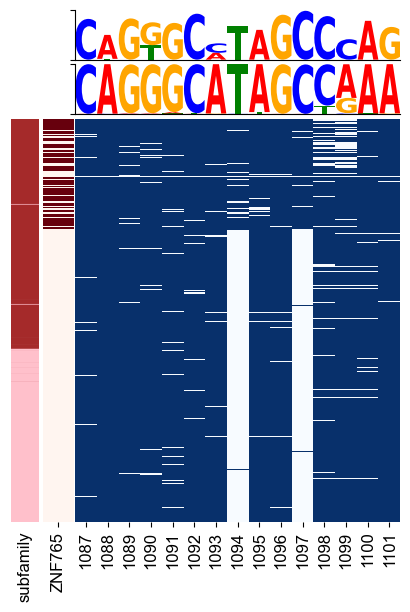

In [16]:
fig = plt.figure(figsize=[7, 7])
gs = GridSpec(20, 50)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

# subfamily
ax = plt.subplot(gs[5:, :3])
i = 3

data = Dfam_RM_fil

for k, name in enumerate(data['repeat name']):

    color = color_name_dict[name]
    y = len(data) - k
    ax.hlines(y, 0, 1, color=color)

ax.set_ylim(0, len(data))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([0.5])
ax.set_xticklabels(['subfamily'], rotation=90)
ax.tick_params(left=False, right=False, bottom=False, top=False)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left', 'bottom']]


# binding profile
ax = plt.subplot(gs[5:, i:i+3])
i += 3

data = Dfam_RM_fil['repeat name'].isin(KZFP['repeat name']).to_frame()

sns.heatmap(data, cmap='Reds', cbar=False, ax=ax)
ax.set_xticklabels([gene], rotation=90)
#ax.set_xticklabels([])
ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)

# match with consensus
ax = plt.subplot(gs[5:, i:i+len(sequence)*2])

data = heatmap
sns.heatmap(data, cmap='Blues', cbar=False, ax=ax)

ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)


# motif
ax = plt.subplot(gs[1:3, i:i+len(sequence)*2])

data = (motif/0.25).apply(np.log2)
data = pd.DataFrame(np.where(data>=0, data, 0), columns=['A', 'C', 'G', 'T'])
motif_color_dict = {'A': 'red', 'T': 'green', 'C': 'blue', 'G': 'orange'}

logomaker.Logo(data, 
               color_scheme=motif_color_dict, 
               ax=ax)

ax.tick_params(bottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([''])
ax.set_ylim(0, 2)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]


# consensus
ax = plt.subplot(gs[3:5, i:i+len(sequence)*2])

data = consensus_matrix_with_KZFP_not_deletion[['A', 'T', 'G', 'C']]
data.index = range(len(data))
motif_color_dict = {'A': 'red', 'T': 'green', 'C': 'blue', 'G': 'orange'}

logomaker.Logo(data, 
               color_scheme=motif_color_dict, 
               ax=ax)

ax.tick_params(bottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([''])
ax.set_ylim(0, 1)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure5/Supplementary Figure5B_ZNF765.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure5/Supplementary Figure5B_ZNF765.pdf', bbox_inches='tight', transparent=True, dpi=300)

plt.show()

## ZNF649

In [17]:
gene = 'ZNF649'

In [18]:
motif = motif_metadata_df_nodup[motif_metadata_df_nodup['KZFP gene symbol']==gene]
motif_start, motif_end = motif[['motif start', 'motif end']].values.astype('int64')[0]

# TE annotation
Dfam_RM_fil = Dfam_RM[Dfam_RM['repeat subfamily name'].isin(['L1P1_5end', 'L1HS_5end'])]
Dfam_RM_fil = Dfam_RM_fil.loc[reversed(Dfam_RM_fil.index)]

# MSA
MSA = MSA_df.loc[Dfam_RM_fil['repeat name']]

# KZFP
start, end = motif_start-50, motif_end+50
KZFP = KZFP_df[(KZFP_df['KZFP gene symbol']==gene) & (KZFP_df['summit position in repeat alignment']>=start) & (KZFP_df['summit position in repeat alignment']<=end) ]


In [19]:
# motif
motif_metadata = motif_metadata_df_nodup[motif_metadata_df_nodup['KZFP gene symbol']==gene]
motif = motif_matrix_df[gene][['A', 'C', 'G', 'T']]

if motif_metadata['motif strand'].values[0] == '-':

    motif = motif.sort_index(ascending=False)[['T', 'G', 'C', 'A']]

sequence = ''
for position in motif.index:

    v = motif.loc[position].sort_values(ascending=False)
    b = v.index[0]
    
    sequence += b

print(sequence)
sequence = list(sequence.lower())

AACGGCACACCAGGAGATTATAT


In [20]:
# consensus sequence derived by TE copies overlapping with KZFP peaks

MSA_KZFP = MSA[MSA.index.isin(KZFP['repeat name'])]
consensus_with_KZFP = ''
consensus_matrix_with_KZFP = list()

for position in MSA_KZFP.columns:

    count = MSA_KZFP[position].value_counts(normalize=True).rename(position)
    consensus_matrix_with_KZFP.append(count)

consensus_matrix_with_KZFP = pd.concat(consensus_matrix_with_KZFP, axis=1).T.fillna(0)
consensus_matrix_with_KZFP = consensus_matrix_with_KZFP[['a', 'g', 'c', 't', '-']]
consensus_matrix_with_KZFP.columns = ['A', 'G', 'C', 'T', '-']

# 欠失を取り除く
consensus_matrix_with_KZFP_not_deletion = consensus_matrix_with_KZFP[consensus_matrix_with_KZFP['-']<0.5]
consensus_matrix_with_KZFP_not_deletion = consensus_matrix_with_KZFP_not_deletion.loc[motif_start-1:motif_end-1]
not_deletion_index = consensus_matrix_with_KZFP_not_deletion.index

consensus_with_KZFP = ''
for position in consensus_matrix_with_KZFP_not_deletion.index:
    
    count = MSA_KZFP[position].value_counts(normalize=True)
    consensus_with_KZFP += count.index[0]

In [21]:
# heatmapについて
heatmap = MSA.T.loc[not_deletion_index].T

for col, base in zip(heatmap.columns, consensus_with_KZFP):
    
    heatmap[col] = heatmap[col]==base

MSA.T.loc[not_deletion_index].T

,345,346,347,348,349,350,351,352,353,354,...,358,359,360,361,362,363,364,365,366,367
L1P1_5end_chrX_dup29,a,a,c,g,g,c,a,c,a,c,...,g,a,g,a,t,t,g,t,a,a
L1HS_5end_chr3_dup46,a,c,t,g,g,c,a,g,a,c,...,g,a,g,g,t,t,t,t,-,c
L1HS_5end_chr8_dup90,a,a,t,g,g,c,a,t,a,c,...,g,a,g,a,t,t,a,t,a,t
L1P1_5end_chr9_dup95,a,a,c,g,g,c,a,c,a,c,...,g,a,g,a,t,t,a,t,a,t
L1P1_5end_chr1_dup54,a,a,c,g,g,c,a,c,a,c,...,g,a,g,a,t,t,a,t,a,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L1HS_5end_chr2_dup40,a,a,c,g,g,c,g,c,a,c,...,g,a,g,a,c,t,a,t,a,t
L1HS_5end_chr8_dup109,a,a,c,g,g,c,g,c,a,c,...,g,a,g,a,c,t,a,t,a,t
L1HS_5end_chr1_dup76,a,a,c,g,g,c,g,c,a,c,...,g,a,g,a,c,t,a,t,a,t
L1HS_5end_chr5_dup87,a,a,c,g,g,c,g,c,a,c,...,g,a,g,a,c,t,a,t,a,t


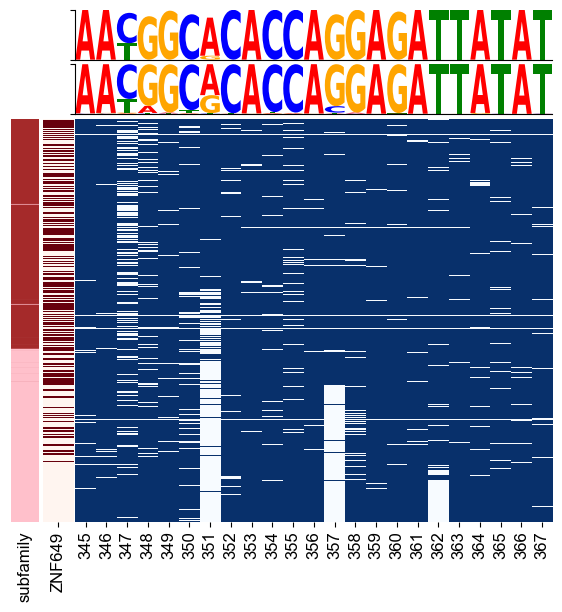

In [22]:
fig = plt.figure(figsize=[7, 7])
gs = GridSpec(20, 50)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

# subfamily
ax = plt.subplot(gs[5:, :3])
i = 3

data = Dfam_RM_fil

for k, name in enumerate(data['repeat name']):

    color = color_name_dict[name]
    y = len(data) - k
    ax.hlines(y, 0, 1, color=color)

ax.set_ylim(0, len(data))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([0.5])
ax.set_xticklabels(['subfamily'], rotation=90)
ax.tick_params(left=False, right=False, bottom=False, top=False)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left', 'bottom']]


# binding profile
ax = plt.subplot(gs[5:, i:i+3])
i += 3

data = Dfam_RM_fil['repeat name'].isin(KZFP['repeat name']).to_frame()

sns.heatmap(data, cmap='Reds', cbar=False, ax=ax)
ax.set_xticklabels([gene], rotation=90)
ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)

# match with consensus
ax = plt.subplot(gs[5:, i:i+len(sequence)*2])

data = heatmap
sns.heatmap(data, cmap='Blues', cbar=False, ax=ax)

ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)


# motif
ax = plt.subplot(gs[1:3, i:i+len(sequence)*2])

data = (motif/0.25).apply(np.log2)
data = pd.DataFrame(np.where(data>=0, data, 0), columns=['A', 'C', 'G', 'T'])
motif_color_dict = {'A': 'red', 'T': 'green', 'C': 'blue', 'G': 'orange'}

logomaker.Logo(data, 
               color_scheme=motif_color_dict, 
               ax=ax)

ax.tick_params(bottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([''])
ax.set_ylim(0, 2)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]


# consensus
ax = plt.subplot(gs[3:5, i:i+len(sequence)*2])

data = consensus_matrix_with_KZFP_not_deletion[['A', 'T', 'G', 'C']]
data.index = range(len(data))
motif_color_dict = {'A': 'red', 'T': 'green', 'C': 'blue', 'G': 'orange'}

logomaker.Logo(data, 
               color_scheme=motif_color_dict, 
               ax=ax)

ax.tick_params(bottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([''])
ax.set_ylim(0, 1)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure5/Supplementary Figure5B_ZNF649.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure5/Supplementary Figure5B_ZNF649.pdf', bbox_inches='tight', transparent=True, dpi=300)

plt.show()

## ZNF93

In [23]:
gene = 'ZNF93'

In [24]:
# TE annotation
Dfam_RM_fil = Dfam_RM[Dfam_RM['repeat subfamily name'].isin(['L1P1_5end', 'L1HS_5end'])]
Dfam_RM_fil = Dfam_RM_fil.loc[reversed(Dfam_RM_fil.index)]

# MSA
MSA = MSA_df.loc[Dfam_RM_fil.index]

# KZFP
start, end = 1500, 2500
KZFP = KZFP_df_fil[(KZFP_df_fil['KZFP gene symbol']==gene) & (KZFP_df_fil['summit position in repeat alignment']>=start) & (KZFP_df_fil['summit position in repeat alignment']<=end) ]


In [25]:
# remove deletion
deletion_df = MSA[list(range(1500, 2500))]!='-'
check = deletion_df.mean(axis=0)>=0.3

position_modified_dict = dict()
count = 1500
for position, deletion in zip(check.index, check.values):

    if deletion==False:

        position_modified_dict[position] = count
        count += 1
    
    else:

        position_modified_dict[position] = count

KZFP['summit position in repeat alignment for ZNF93'] = KZFP['summit position in repeat alignment'].apply(lambda x:position_modified_dict[x])
deletion_fil = deletion_df.T.loc[check].T
deletion_fil.columns = range(1500, 1500+len(deletion_fil.columns))

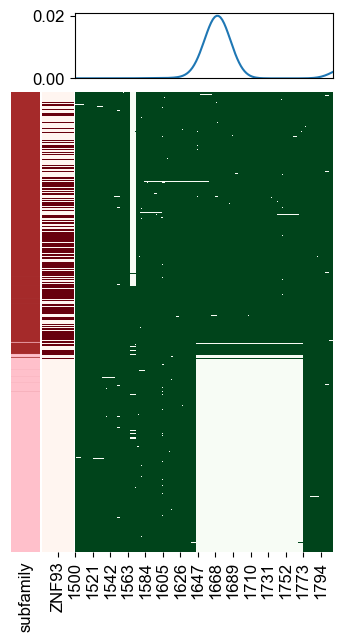

In [26]:
fig = plt.figure(figsize=[5, 7])
gs = GridSpec(7, 60)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

# subfamily
ax = plt.subplot(gs[1:, :5])
data = Dfam_RM_fil

for i, name in enumerate(data['repeat name']):

    color = color_name_dict[name]
    y = len(data) - i
    ax.hlines(y, 0, 1, color=color)

ax.set_ylim(0, len(data))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([0.5])
ax.set_xticklabels(['subfamily'], rotation=90)
ax.tick_params(left=False, right=False, bottom=False, top=False)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left', 'bottom']]


# binding profile
ax = plt.subplot(gs[1:, 5:10])
data = Dfam_RM_fil['repeat name'].isin(KZFP['repeat name']).to_frame()

sns.heatmap(data, cmap='Reds', cbar=False, ax=ax)
ax.set_xticklabels(['ZNF93'], rotation=90)
ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)

# summit position of KZFP
ax = plt.subplot(gs[:1, 10:50])
data = KZFP['summit position in repeat alignment for ZNF93']

sns.kdeplot(data, ax=ax)

ax.set_xlim(1500, 1809)
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_xlabel('')
ax.tick_params(bottom=False)

# deletion
ax = plt.subplot(gs[1:, 10:50])

sns.heatmap(deletion_fil, cmap='Greens', cbar=False, ax=ax)

ax.set_yticklabels([])
ax.set_ylabel('')
ax.tick_params(left=False)

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure5/Supplementary Figure5B_ZNF93.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure5/Supplementary Figure5B_ZNF93.pdf', bbox_inches='tight', transparent=True, dpi=300)
